### A Comparison of Logit, Support Vector and Decision Tree Classification Models on UCI Dataset: An Illustration

"""

Specifics of the model and data used here:
Dataset link: 			https://tinyurl.com/n69koxd from UCI ML Repository 
Modeling language: 		Python 3.5
Modeling environment: 	Jupyter Notebooks, Spyder (and R for XGBoost)
Primary libraries used: 		matplotlib, pandas, seaborn, scikit-learn, numpy, keras 

Brief overview of the dataset:
The data pertains to the success of telemarketing campaign carried out by a Portuguese banking institution. The dataset 
provides us with a binary classification problem. The success of the campaign is measured by how many clients subscribe 
to the term-deposit offer made by the institution. The “success” is the classification variable of interest represented by “1” 
(the other outcome is “failure” / “0”). 

Together with 9 numeric variables, and 11 categorical variables, the data contains a set of 20 features, not including the 
classification variable. The categorical variables include different aspects such as education, previous defaults, existing 
mortgages, sex and marital status, among others. The variable employment variation rate (“emp.var.rate” ) is not intuitively
clear and a very limited description is provided. It is not obvious as to how this factor might affect the outcome of
interest. 

The number of samples is at a healthy 41,118. The dataset contains a total of 41188 x 20 data points (plus the label). 
(Before proceeding it is recommended that the reader have a look at the data which is available at the UCI machine learning 
page.)

"""

Note: The model is built for illstration and discussion purposes. For more challenging problems would require iterative adaptations of data preparation, hyperparamter tuning and output interpretation.

###### Model Selection Criteria

Model building is an iterative process. Once we are satisfied that sample dataset is adequately representative of the larger population, we can move on to examine objective of our model. (On a sidenote, methods of drawing samples from the universe of available data is a discipline in itself and is domain dependent).

For the task at hand, we are required to build a classification model to predict the success of the marketing campaign for a term-deposit being offered by a Portuguese bank. Like in most cases, we design and implement a set of classification models and select the ones which satisfy (or exceed) a set of preset criteria.

Since we do not have cost-functions assigned to 'False' predictions, we have to intuitively examine and construct which is worse, 'False negatives' or 'False positives'. 

Benefit of ['True Positives']: We notice that a 'True positive' in this case is a call being correctly predicted to be successful in convincing a client to subscribing the term-deposit offer. (A predicted true negative would be a call which was predicted as having no benefit to the bank.) 

Costs of ['False positives'] and ['False negatives']: The cost of a false positive is that a call predicted to be successful will not turn out to be so. And the associated costs would include the embedded cost of person-hours for these types of calls. The cost of a false negative however, would be higher since a call which resulted in a subscrition of offer was predicted to be successful, hence, presumably it did not warrant sufficient attention/resources as part of the preliminary planning.

Let us set the follwing scores (reasoning provided below):

Accuracy - 60% or above (S1)

Recall - 75% or above   (S2)

F1 score - 70% minimum

ROC AUC for the model - 0.80 

Reasoning:

S1 - given that we are building a model on the outcome of a marketing campaign, we can seldom aim for high accuracy (>80%). Speaking from experience, marketing data tends to have a higher noise-to-signal ratio and than data generated in a more controlled environment. If our model can classify the true positives (correctly) 6 out 10 times, we can learn a lot from the model.  

S2 - gleaning from the dataset on hand, there are a lot more datapoints for true negatives. By design our machine learning models will learn (fit) better how to predict a true negative than a true positive, hence we can set a higher threshold for this.  

The F1 score is set at 70%.

We will use scikit-learn's built-in metrics functions and generate the evaluation scores.

In [1]:
#Import the most commonly used libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('bank_data.csv')
df.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
weekday,mon,mon,mon,mon,mon


Let's examine the data in a brief way. 

In [3]:
#check for missing values
df.isnull().sum()

#or use, 
#sum(df.isnull().values.ravel())

age             0
job             0
marital         0
education       0
default         0
housing         0
loan            0
contact         0
month           0
weekday         0
duration        0
campaign        0
p_days          0
Previous        0
poutcome        0
emp_var_rate    0
cpi             0
cci             0
euribor3m       0
no_emp          0
yes_no          0
dtype: int64

In [4]:
#Check datatype in the DF
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age             41188 non-null int64
job             41188 non-null object
marital         41188 non-null object
education       41188 non-null object
default         41188 non-null object
housing         41188 non-null object
loan            41188 non-null object
contact         41188 non-null object
month           41188 non-null object
weekday         41188 non-null object
duration        41188 non-null int64
campaign        41188 non-null int64
p_days          41188 non-null int64
Previous        41188 non-null int64
poutcome        41188 non-null object
emp_var_rate    41188 non-null float64
cpi             41188 non-null float64
cci             41188 non-null float64
euribor3m       41188 non-null float64
no_emp          41188 non-null float64
yes_no          41188 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usage: 6.6+ MB


In [5]:
#quick check for unusual values in numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
p_days,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
Previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp_var_rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cpi,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cci,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
no_emp,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


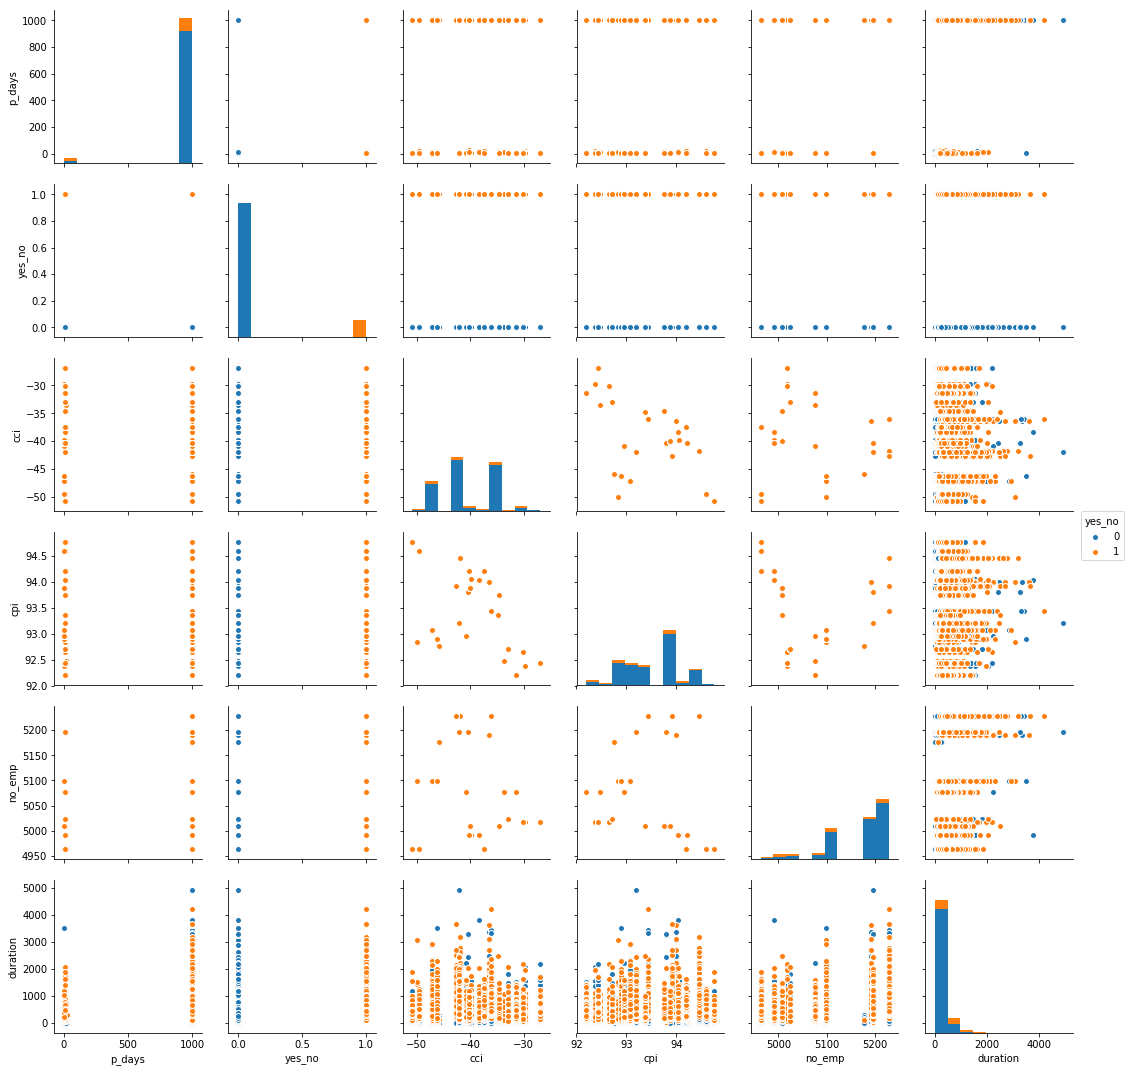

In [6]:
#A quick EDA using seasborn's pairplot
fig1 = sns.pairplot(df[['p_days', 'yes_no', 'cci', 'cpi', 'no_emp', 'duration']], hue='yes_no')

#several combinations of graphical EDA are carried out. This document does not include most of it.

In [7]:
#extracting column names for prccessing categorical features
bank_feats = df.columns.values.tolist()

In [8]:
#Separating the dependent and independent variables 

X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

In [10]:
#check for df shape
X.shape

(41188, 20)

In [11]:
#extract labels from the categorical features

marital_labels = np.unique(X["marital"])
job_labels = np.unique(X["job"])
edu_labels = np.unique(X["education"])
default_labels = np.unique(X['default'])
housing_labels = np.unique(X['housing'])
loan_labels = np.unique(X['loan'])
contact_labels = np.unique(X['contact'])
month_labels = np.unique(X['month'])
wk_labels = np.unique(X["weekday"])
campaign_labels = np.unique(X['campaign'])
poutcome_labels = np.unique(X['poutcome'])

In [12]:
#initiate functions from the label encoding libraries
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
labelencoder_X = LabelEncoder()
onehotencoder = OneHotEncoder(categorical_features=[0])


In [13]:
#Label encoding for categorical variables

mar = pd.DataFrame(labelencoder_X.fit_transform(X["marital"]))
job = pd.DataFrame(labelencoder_X.fit_transform(X["job"]))
edu = pd.DataFrame(labelencoder_X.fit_transform(X["education"]))
dfl = pd.DataFrame(labelencoder_X.fit_transform(X["default"]))
hou = pd.DataFrame(labelencoder_X.fit_transform(X["housing"]))
lon = pd.DataFrame(labelencoder_X.fit_transform(X["loan"]))
con = pd.DataFrame(labelencoder_X.fit_transform(X["contact"]))
mon = pd.DataFrame(labelencoder_X.fit_transform(X["month"]))
wkd = pd.DataFrame(labelencoder_X.fit_transform(X["weekday"]))
cam = pd.DataFrame(labelencoder_X.fit_transform(X["campaign"]))
pot = pd.DataFrame(labelencoder_X.fit_transform(X["poutcome"]))

In [14]:
#Create new temporary dfs for onehotencoding categorical features

mar = pd.DataFrame(onehotencoder.fit_transform(mar).toarray())
mar.columns = marital_labels

job = pd.DataFrame(onehotencoder.fit_transform(job).toarray())
job.columns = job_labels

edu = pd.DataFrame(onehotencoder.fit_transform(edu).toarray())
edu.columns = edu_labels

dfl =  pd.DataFrame(onehotencoder.fit_transform(dfl).toarray())
dfl.columns = default_labels

hou = pd.DataFrame(onehotencoder.fit_transform(hou).toarray())
hou.columns = housing_labels

lon =  pd.DataFrame(onehotencoder.fit_transform(lon).toarray())
lon.columns = loan_labels

con =  pd.DataFrame(onehotencoder.fit_transform(con).toarray())
con.columns = contact_labels

mon = pd.DataFrame(onehotencoder.fit_transform(mon).toarray())
mon.columns = month_labels

wkd = pd.DataFrame(onehotencoder.fit_transform(wkd).toarray())
wkd.columns = wk_labels

cam = pd.DataFrame(onehotencoder.fit_transform(cam).toarray())
cam.columns = campaign_labels

pot = pd.DataFrame(onehotencoder.fit_transform(pot).toarray())
pot.columns = poutcome_labels

In [15]:
#Drop and concatinate with new tables

X.drop(["job", "marital", "education", "default", "housing", "loan", "contact", "month", "weekday", "campaign", "poutcome"], 
      axis=1, inplace=True)

In [16]:
cat_table1 = pd.DataFrame(pd.concat((mar, job, edu, dfl, hou, lon, con, mon, wkd, cam, pot), axis=1))

In [17]:
X = pd.DataFrame(pd.concat((X, cat_table1), axis=1))

In [18]:
X.shape

(41188, 104)

In [19]:
#X.to_csv("X_process_data.csv")

In [20]:
#split the dataset for training and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
#Scale the features for more accurate models and to conserve computational resources 

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
# reshape y variables into an (ndim) array which is required for certain classifiers like the support vector machines suite
y_train = y_train.values             #convert to numpy array
r, c = y_train.shape           #extract shape
y = y_train.reshape(r,)        #reshape
y_train.shape


(32950, 1)

In [23]:
#Let's use the SciKit's LogisticRegressor
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression(max_iter=500, C=0.5, random_state=52)

In [24]:
logit_model.fit(X_train, y_train)

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=52, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
y_preds_logit = logit_model.predict(X_test)

In [26]:
#Let's examine the performance of the model
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
print(classification_report(y_preds_logit, y_test))
print(confusion_matrix(y_preds_logit, y_test))

             precision    recall  f1-score   support

          0       0.97      0.93      0.95      7641
          1       0.42      0.66      0.51       597

avg / total       0.93      0.91      0.92      8238

[[7093  548]
 [ 202  395]]


In [28]:
logit_cm = confusion_matrix(y_preds_logit, y_test, [1,0])

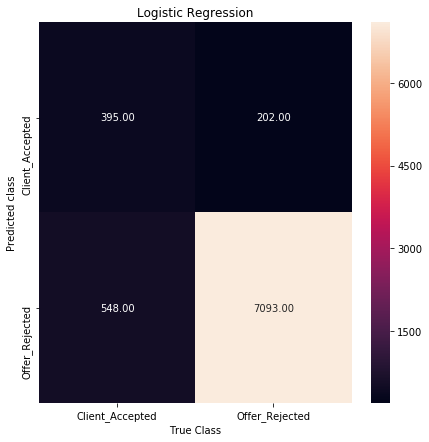

In [29]:
plt.figure(figsize=(7,7))
sns.heatmap(logit_cm, annot=True, fmt='.2f',xticklabels = ["Client_Accepted", "Offer_Rejected"] , yticklabels = ["Client_Accepted", "Offer_Rejected"] )
plt.ylabel('Predicted class')
plt.xlabel('True Class')
plt.title('Logistic Regression')
plt.savefig('logistic_regression')

#### Let's Plot the ROC Curve

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [31]:
logit_roc_auc = roc_auc_score(y_test, logit_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logit_model.predict_proba(X_test)[:,1])

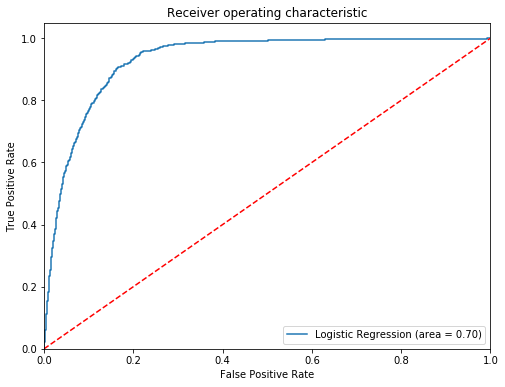

In [32]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

In [33]:
from sklearn.svm import SVC
svc_model = SVC(kernel = 'rbf', C=1.0, probability=True)

In [34]:
svc_model.fit(X_train, y_train)

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
y_preds_svc = svc_model.predict(X_test)

In [40]:
print(classification_report(y_test, y_preds_svc))
print(confusion_matrix(y_test, y_preds_svc))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95      7295
          1       0.67      0.39      0.49       943

avg / total       0.90      0.91      0.90      8238

[[7110  185]
 [ 572  371]]


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
svc_cm = confusion_matrix(y_preds_svc, y_test, [1,0])

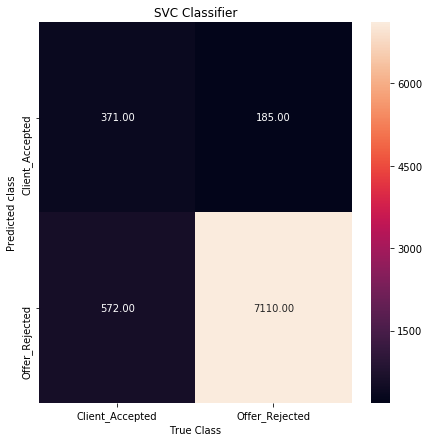

In [44]:
plt.figure(figsize=(7,7))
sns.heatmap(svc_cm, annot=True, fmt='.2f',xticklabels = ["Client_Accepted", "Offer_Rejected"] , yticklabels = ["Client_Accepted", "Offer_Rejected"] )
plt.ylabel('Predicted class')
plt.xlabel('True Class')
plt.title('SVC Classifier')
plt.savefig('SVC Classifier')

In [45]:
svc_roc_auc = roc_auc_score(y_test, svc_model.predict(X_test))
fpr_svc, tpr_svc, thresholds = roc_curve(y_test, svc_model.predict_proba(X_test)[:,1])

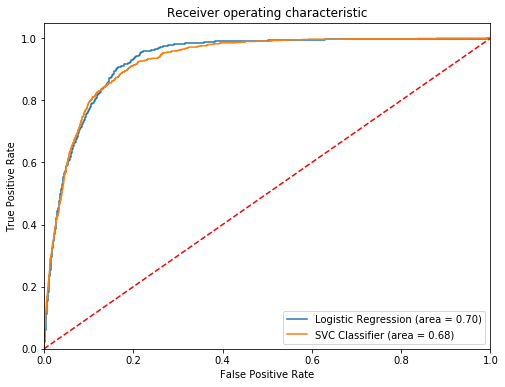

In [46]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_svc, tpr_svc, label='SVC Classifier (area = %0.2f)' % svc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
dtree_model = DecisionTreeClassifier()

In [49]:
dtree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [50]:
y_preds_dt = dtree_model.predict(X_test)

In [51]:
print(classification_report(y_test, y_preds_dt))
print(confusion_matrix(y_test, y_preds_dt))

             precision    recall  f1-score   support

          0       0.94      0.93      0.94      7295
          1       0.50      0.52      0.51       943

avg / total       0.89      0.89      0.89      8238

[[6817  478]
 [ 456  487]]


In [56]:
dtree_cm = confusion_matrix(y_preds_dt, y_test, [1,0])

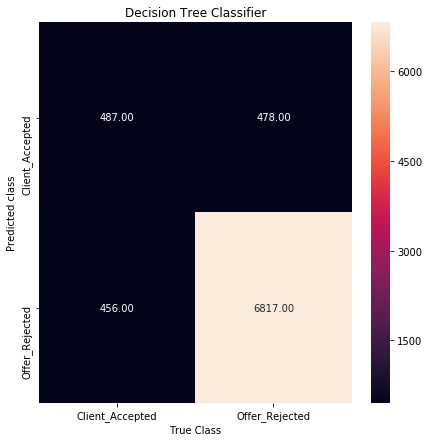

In [57]:
plt.figure(figsize=(7,7))
sns.heatmap(dtree_cm, annot=True, fmt='.2f',xticklabels = ["Client_Accepted", "Offer_Rejected"] , yticklabels = ["Client_Accepted", "Offer_Rejected"] )
plt.ylabel('Predicted class')
plt.xlabel('True Class')
plt.title('Decision Tree Classifier')
plt.savefig('Decision Tree Classifier')

In [58]:
dtree_roc_auc = roc_auc_score(y_test, dtree_model.predict(X_test))
fpr_dtree, tpr_dtree, thresholds = roc_curve(y_test, dtree_model.predict_proba(X_test)[:,1])

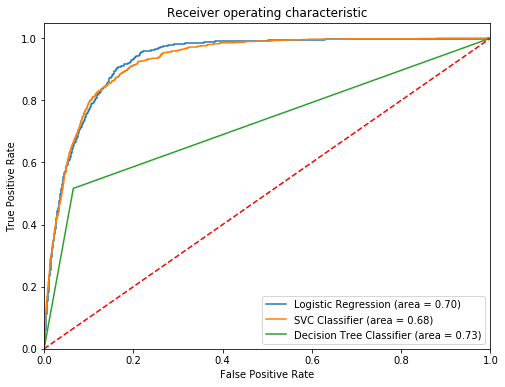

In [59]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_svc, tpr_svc, label='SVC Classifier (area = %0.2f)' % svc_roc_auc)
plt.plot(fpr_dtree, tpr_dtree, label='Decision Tree Classifier (area = %0.2f)' % dtree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

#### Which model to choose?

Out of the three models we deployed, we see that the simple support vector classifier with 'rbf' kernel, somewhat surprisingly, had the lowest performance scores in terms of false negatives, i.e. marking a potentially profitable call as 'reject'. However, its performance with respect to marking true negatives is comparable to the logistic classifer. Perhaps it shouldn't be too surprising since the SVC we started out with had default values, and it is likely that the model will improve after GridSearch and tuning the hyperparameters. The decision tree model was the best performing of the three in terms of having the highest true positives and lowest false negatives. However, the model fell short in predicting true negatives, which could mean that bank's telemarketing calls annoyed a few more clients than the model predicts.

We observe that all the models have high average F1 score of between 89-92%. The high average perfomance score is due to more accurate predictions of negative outcomes ("rejects"). 

In terms of ROC curves, both the SVC classifier and the logistic regression models fell short. The decision tree model with an ROC-AUC of 0.73 came closer to meeting our threshold criteria. 

According to the criteria we set at the start, the model that (somewhat) meets our performance requirements is the decision tree classifier. But we can do better!

#### Side-note: 

I was curious to see how well the XGBoost model fits the dataset. So I built a model in R (I had to do it in R since, my python notebook sometimes freezes while running XGBoost models). It turns out the model had an overall accuracy of about 95%. Since XGBoost models tend to fit the training data well, the differential improvement vis-a-vis other models isn't too surprising. The complete R code can be found in the same folder.

### What are our models learning? And how can we make them better.

Our models learn from the data we feed them. The more datapoints they have about a particular outcomes of interest, the better the algorithms learn the combination of features that leads to an event. Sometimes the training data might be significantly different from the test data which case the performance of the model would be way off the mark. In case of model trained here, it is good with respect to predictive true negatives and somewhat lower false positives. Taking a look at the "Classification Reports" of all three models, we notice that there's high precision and recall for prediction of true negatives. The model is better at predicting client rejections than it is at predicting client acceptance. However, we are more interested in predicting successful outcomes (client acceptance). We should look at how to improve this. 

When we examine the dataset we see that the total number of positive outcomes numbered at 4640, out of a total of 41188 (the rest were negative outcomes/"client rejections"). Since we split the data randomly using "train_test_split" function, it'd have carried over the same ratio of acceptance/rejection, and the model systematically weights its learnings more from the rejections. The model needs to give more weightage to learn from "acceptance" (1) cases. One of the ways of doing it is by stratifying the training dataset (using stratify and shufflesplit functions) and another way is to tune the hyperparameters of the classifiers. Let's try out the second option.

In [60]:
logit_model_weighted = LogisticRegression(max_iter=500, C=0.5, random_state=52, class_weight='balanced')

In [61]:
logit_model_weighted.fit(X_train, y_train)

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=52,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [62]:
y_preds_logit_w = logit_model_weighted.predict(X_test)

In [63]:
#Let's examine the performance of the model
from sklearn.metrics import classification_report, confusion_matrix

In [64]:
print(classification_report(y_preds_logit_w, y_test))
print(confusion_matrix(y_preds_logit_w, y_test))

             precision    recall  f1-score   support

          0       0.86      0.98      0.92      6413
          1       0.86      0.44      0.59      1825

avg / total       0.86      0.86      0.84      8238

[[6281  132]
 [1014  811]]


In [65]:
logit_cm_w = confusion_matrix(y_preds_logit_w, y_test, [1,0])

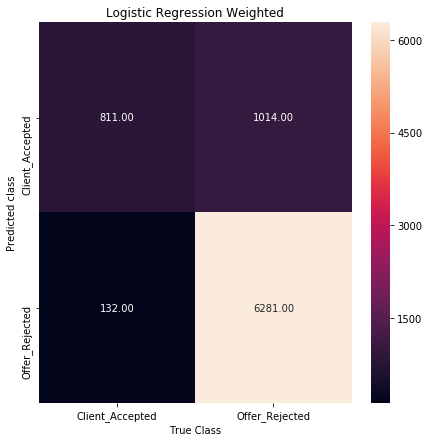

In [66]:
plt.figure(figsize=(7,7))
sns.heatmap(logit_cm_w, annot=True, fmt='.2f',xticklabels = ["Client_Accepted", "Offer_Rejected"] , yticklabels = ["Client_Accepted", "Offer_Rejected"] )
plt.ylabel('Predicted class')
plt.xlabel('True Class')
plt.title('Logistic Regression Weighted')
plt.savefig('logistic_regression_weighted')

In [67]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [70]:
logit_roc_auc_w = roc_auc_score(y_test, logit_model_weighted.predict(X_test))
fpr_w, tpr_w, thresholds = roc_curve(y_test, logit_model_weighted.predict_proba(X_test)[:,1])

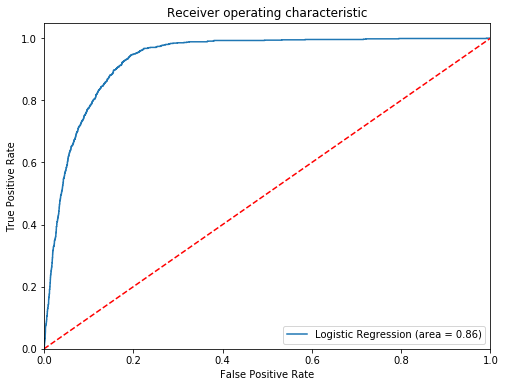

In [71]:
plt.figure(figsize=(8,6))
plt.plot(fpr_w, tpr_w, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_w)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

In [72]:
from sklearn.svm import SVC
svc_model_weighted = SVC(kernel = 'rbf', C=1.0, probability=True, class_weight='balanced')

In [73]:
svc_model_weighted.fit(X_train, y_train)

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [74]:
y_preds_svc_w = svc_model_weighted.predict(X_test)

In [76]:
print(classification_report(y_test, y_preds_svc_w))
print(confusion_matrix(y_test, y_preds_svc_w))

             precision    recall  f1-score   support

          0       0.98      0.86      0.92      7295
          1       0.45      0.88      0.59       943

avg / total       0.92      0.86      0.88      8238

[[6278 1017]
 [ 117  826]]


In [77]:
from sklearn.metrics import classification_report, confusion_matrix
svc_cm_w = confusion_matrix(y_preds_svc_w, y_test, [1,0])

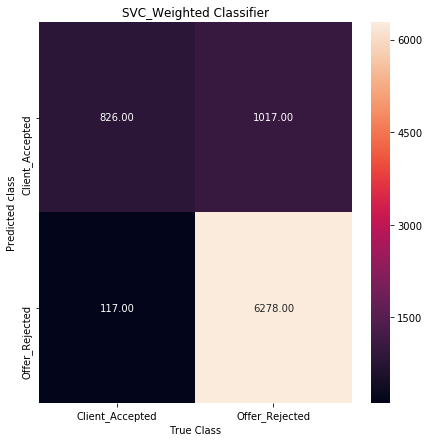

In [78]:
plt.figure(figsize=(7,7))
sns.heatmap(svc_cm_w, annot=True, fmt='.2f',xticklabels = ["Client_Accepted", "Offer_Rejected"] , yticklabels = ["Client_Accepted", "Offer_Rejected"] )
plt.ylabel('Predicted class')
plt.xlabel('True Class')
plt.title('SVC_Weighted Classifier')
plt.savefig('SVC_W Classifier')

In [79]:
svc_roc_auc_w = roc_auc_score(y_test, svc_model_weighted.predict(X_test))
fpr_svc_w, tpr_svc_w, thresholds = roc_curve(y_test, svc_model_weighted.predict_proba(X_test)[:,1])

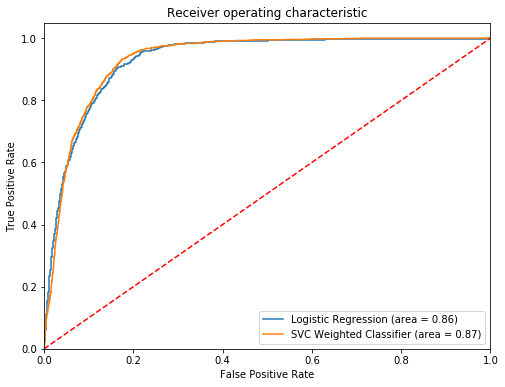

In [80]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_w)
plt.plot(fpr_svc_w, tpr_svc_w, label='SVC Weighted Classifier (area = %0.2f)' % svc_roc_auc_w)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

In [81]:
from sklearn.tree import DecisionTreeClassifier
dtree_model_weighted = DecisionTreeClassifier(class_weight='balanced')

In [82]:
dtree_model_weighted.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [83]:
y_preds_dt_w = dtree_model_weighted.predict(X_test)

In [84]:
print(classification_report(y_test, y_preds_dt_w))
print(confusion_matrix(y_test, y_preds_dt_w))

             precision    recall  f1-score   support

          0       0.93      0.94      0.94      7295
          1       0.52      0.48      0.50       943

avg / total       0.89      0.89      0.89      8238

[[6875  420]
 [ 494  449]]


In [85]:
dtree_cm_w = confusion_matrix(y_preds_dt_w, y_test, [1,0])

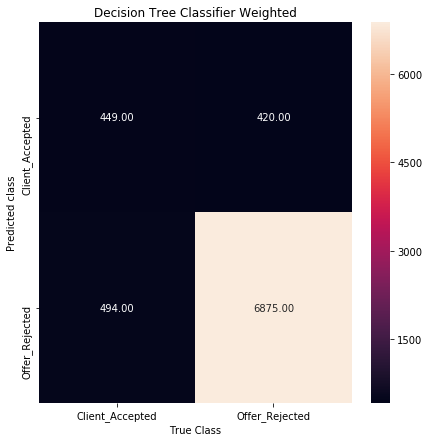

In [86]:
plt.figure(figsize=(7,7))
sns.heatmap(dtree_cm_w, annot=True, fmt='.2f',xticklabels = ["Client_Accepted", "Offer_Rejected"] , yticklabels = ["Client_Accepted", "Offer_Rejected"] )
plt.ylabel('Predicted class')
plt.xlabel('True Class')
plt.title('Decision Tree Classifier Weighted')
plt.savefig('Decision Tree Classifier Weighted')

In [87]:
dtree_roc_auc_w = roc_auc_score(y_test, dtree_model_weighted.predict(X_test))
fpr_dtree_w, tpr_dtree_w, thresholds = roc_curve(y_test, dtree_model_weighted.predict_proba(X_test)[:,1])

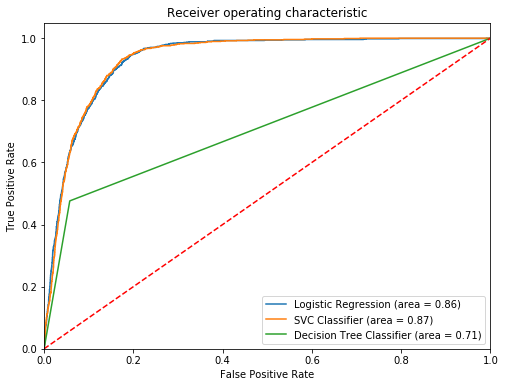

In [88]:
plt.figure(figsize=(8,6))
plt.plot(fpr_w, tpr_w, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_w)
plt.plot(fpr_svc_w, tpr_svc_w, label='SVC Classifier (area = %0.2f)' % svc_roc_auc_w)
plt.plot(fpr_dtree_w, tpr_dtree_w, label='Decision Tree Classifier (area = %0.2f)' % dtree_roc_auc_w)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

We see that the AUC predictions has improved from 0.7 to over 0.85. That's a pretty good improvement from tuning the hyperparamter! 

Let's analyze the performance of weighted classifiers; we'll start with sklearn's confusion matrix. We see that both the logistic classifier and the support vector classifier performed much better with predicting true positives (logit 811/395 and 826/371) but at the cost of higher false positives. This is because of precision/recall trade-off. (There's a separate post on precision-recall trade-off.) 

Side-Note: Observe that there is not a whole lot of improvement in predictive accuracy with the weighted decision tree (in fact the AUC has slightly decreased). Why? It is because of those attributes which make tree models robust to the presence of outliers, that make it resistant to weighting less-frequent classes. We will explore this in a different post.

It is important to note that we can finetune the existing models to improve performance and/or attempt to fit other models. In some cases, we can also build ensemble models, but they are usually hard to interpret. 